In [1]:
#Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import spacy
from nltk.probability import FreqDist
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder

pd.set_option('display.max_colwidth', 300)

In [67]:
def evaluate_classification_network(model, 
                                    X_train=None, y_train=None, 
                                    X_test=None, y_test=None,
                                    history=None, history_figsize=(6,6),
                                    figsize=(6,4), normalize='true',
                                    output_dict = False,
                                    cmap_train='Blues',
                                    cmap_test="Reds",
                                    values_format=".2f", 
                                    colorbar=False):
    """Evaluates a neural network classification task using either
    separate X and y arrays or a tensorflow Dataset
    
    Data Args:
        X_train (array, or Dataset)
        y_train (array, or None if using a Dataset
        X_test (array, or Dataset)
        y_test (array, or None if using a Dataset)
        history (history object)
        """
    # Plot history, if provided
    if history is not None:
        plot_history(history, figsize=history_figsize)
    ## Adding a Print Header
    print("\n"+'='*80)
    print('- Evaluating Network...')
    print('='*80)
    ## TRAINING DATA EVALUATION
    # check if X_train was provided
    if X_train is not None:
        ## Check if X_train is a dataset
        if hasattr(X_train,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_train, y_train_pred = get_true_pred_labels(model, X_train)
        else:
            # Get predictions for training data
            y_train_pred = model.predict(X_train)
        ## Pass both y-vars through helper compatibility function
        y_train = convert_y_to_sklearn_classes(y_train)
        y_train_pred = convert_y_to_sklearn_classes(y_train_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_train = classification_metrics(y_train, y_train_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_train,
                                               values_format=values_format,
                                         label='Training Data')
        
        ## Run model.evaluate         
        print("\n- Evaluating Training Data:")
        print(model.evaluate(X_train, return_dict=True))
    
    # If no X_train, then save empty list for results_train
    else:
        results_train = []
    ## TEST DATA EVALUATION
    # check if X_test was provided
    if X_test is not None:
        ## Check if X_train is a dataset
        if hasattr(X_test,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_test, y_test_pred = get_true_pred_labels(model, X_test)
        else:
            # Get predictions for training data
            y_test_pred = model.predict(X_test)
        ## Pass both y-vars through helper compatibility function
        y_test = convert_y_to_sklearn_classes(y_test)
        y_test_pred = convert_y_to_sklearn_classes(y_test_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_test = classification_metrics(y_test, y_test_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_test,
                                              values_format=values_format,
                                         label='Test Data')
        
        ## Run model.evaluate         
        print("\n- Evaluating Test Data:")
        print(model.evaluate(X_test, return_dict=True))
      
    # If no X_test, then save empty list for results_test
    else:
        results_test = []
      
    # Store results in a dictionary
    results_dict = {'train':results_train,
                    'test': results_test}
    if output_dict == True:
        return results_dict

In [69]:
def plot_history(history,figsize=(6,8)):
    # Get a unique list of metrics 
    all_metrics = np.unique([k.replace('val_','') for k in history.history.keys()])
    # Plot each metric
    n_plots = len(all_metrics)
    fig, axes = plt.subplots(nrows=n_plots, figsize=figsize)
    axes = axes.flatten()
    # Loop through metric names add get an index for the axes
    for i, metric in enumerate(all_metrics):
        # Get the epochs and metric values
        epochs = history.epoch
        score = history.history[metric]
        # Plot the training results
        axes[i].plot(epochs, score, label=metric, marker='.')
        # Plot val results (if they exist)
        try:
            val_score = history.history[f"val_{metric}"]
            axes[i].plot(epochs, val_score, label=f"val_{metric}",marker='.')
        except:
            pass
        finally:
            axes[i].legend()
            axes[i].set(title=metric, xlabel="Epoch",ylabel=metric)
    # Adjust subplots and show
    fig.tight_layout()
    plt.show()

## Data Processing

In [2]:
#Loading Data
df = pd.read_csv('Data_NLP/movie_reviews_v2.csv')
df.head()

,review_id,movie_id,imdb_id,original_title,review,rating
0,64ecc16e83901800af821d50,843,tt0118694,花樣年華,"This is a fine piece of cinema from Wong Kar-Wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. We start with two couples who move into a new building. One a newspaper man with his wife, the other a business executive and his wife. The ...",7.0
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy animation.",9.0
2,5bb5ac829251410dcb00810c,7443,tt0120630,Chicken Run,"Made my roommate who hates stop-motion animation watched this in 2018 and even he had a good time. It's maybe not as great as I remember thinking it was when I was a little kid, but it still holds up to some degree.\r\n\r\n_Final rating:★★★ - I liked it. Would personally recommend you give it a ...",6.0
3,5f0c53a013a32000357ec505,7443,tt0120630,Chicken Run,"A very good stop-motion animation!\r\n\r\n<em>'Chicken Run'</em>, which I watched a crap tonne when I was little but not for a vast number of years now, is an impressive production given it came out in 2000. Despite a pretty simple feel to the film, it's a very well developed concept.\r\n\r\nThe...",8.0
4,64ecc027594c9400ffe77c91,7443,tt0120630,Chicken Run,"Ok, there is an huge temptation to riddle this review with puns - but I'm just going to say it's a cracking little family adventure. It's seemingly based on a whole range of classic movies from the ""Great Escape"", ""Star Trek"" to ""Love Story"" with a score cannibalised from just about any/everythi...",7.0


In [3]:
df.info()
print('\nMissing Values:', df.isna().sum().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8650 entries, 0 to 8649
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   review_id       8650 non-null   object 
 1   movie_id        8650 non-null   int64  
 2   imdb_id         8650 non-null   object 
 3   original_title  8650 non-null   object 
 4   review          8650 non-null   object 
 5   rating          7454 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 405.6+ KB

Missing Values: 1196


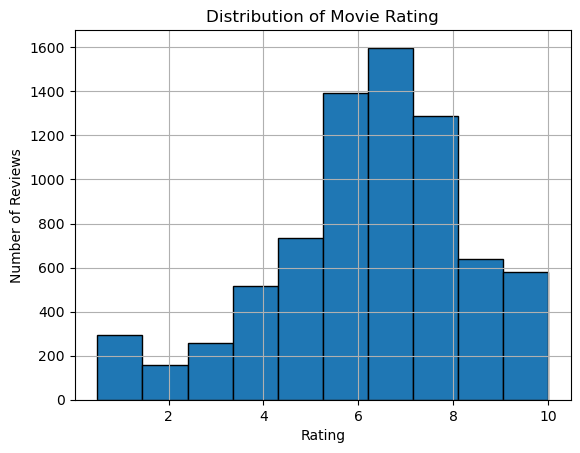

In [4]:
#Making Histogram Plot
ax = df['rating'].hist(bins=10, edgecolor='black')
ax.set_title('Distribution of Movie Rating')
ax.set_xlabel('Rating')
ax.set_ylabel('Number of Reviews');

In [5]:
#Function for new target column
def create_groups(x):
    if x >= 9:
        return 'High'
    elif x <= 4:
        return 'Low'
    else:
        return None

In [6]:
## Using the function to create a new "rating" column with groups
df['new_rating'] = df['rating'].map(create_groups)
df['new_rating'].value_counts(dropna=False)

None    6231
Low     1224
High    1195
Name: new_rating, dtype: int64

In [7]:
#Dropping old "rating" column
df = df.drop(columns='rating')
df.head()

,review_id,movie_id,imdb_id,original_title,review,new_rating
0,64ecc16e83901800af821d50,843,tt0118694,花樣年華,"This is a fine piece of cinema from Wong Kar-Wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. We start with two couples who move into a new building. One a newspaper man with his wife, the other a business executive and his wife. The ...",None
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy animation.",High
2,5bb5ac829251410dcb00810c,7443,tt0120630,Chicken Run,"Made my roommate who hates stop-motion animation watched this in 2018 and even he had a good time. It's maybe not as great as I remember thinking it was when I was a little kid, but it still holds up to some degree.\r\n\r\n_Final rating:★★★ - I liked it. Would personally recommend you give it a ...",None
3,5f0c53a013a32000357ec505,7443,tt0120630,Chicken Run,"A very good stop-motion animation!\r\n\r\n<em>'Chicken Run'</em>, which I watched a crap tonne when I was little but not for a vast number of years now, is an impressive production given it came out in 2000. Despite a pretty simple feel to the film, it's a very well developed concept.\r\n\r\nThe...",None
4,64ecc027594c9400ffe77c91,7443,tt0120630,Chicken Run,"Ok, there is an huge temptation to riddle this review with puns - but I'm just going to say it's a cracking little family adventure. It's seemingly based on a whole range of classic movies from the ""Great Escape"", ""Star Trek"" to ""Love Story"" with a score cannibalised from just about any/everythi...",None


In [8]:
# removing special character ★ 🤣
char_pattern = r'[★½=⭐><]'
characters = df['review'].str.contains(char_pattern)
characters.sum()

1396

In [9]:
# removing star from review 

df = df.loc[~(characters)]

# confirming for star
characters = df['review'].str.contains(char_pattern)
characters.sum()

0

In [10]:
#Normalizing Reviews
df['lower_review'] = df['review'].str.lower()
df.head(3)

,review_id,movie_id,imdb_id,original_title,review,new_rating,lower_review
0,64ecc16e83901800af821d50,843,tt0118694,花樣年華,"This is a fine piece of cinema from Wong Kar-Wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. We start with two couples who move into a new building. One a newspaper man with his wife, the other a business executive and his wife. The ...",None,"this is a fine piece of cinema from wong kar-wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. we start with two couples who move into a new building. one a newspaper man with his wife, the other a business executive and his wife. the ..."
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy animation.",High,"a guilty pleasure for me personally, as i love both 'the great escape' and most of the works i have seen, over the years, from this rightfully-esteemed british animation company. highly recommended both for children and for adults who enjoy animation."
4,64ecc027594c9400ffe77c91,7443,tt0120630,Chicken Run,"Ok, there is an huge temptation to riddle this review with puns - but I'm just going to say it's a cracking little family adventure. It's seemingly based on a whole range of classic movies from the ""Great Escape"", ""Star Trek"" to ""Love Story"" with a score cannibalised from just about any/everythi...",None,"ok, there is an huge temptation to riddle this review with puns - but i'm just going to say it's a cracking little family adventure. it's seemingly based on a whole range of classic movies from the ""great escape"", ""star trek"" to ""love story"" with a score cannibalised from just about any/everythi..."


In [11]:
#Tokenizing Reviews
df['tokens'] = df['lower_review'].apply(nltk.word_tokenize)
df.head(3)

,review_id,movie_id,imdb_id,original_title,review,new_rating,lower_review,tokens
0,64ecc16e83901800af821d50,843,tt0118694,花樣年華,"This is a fine piece of cinema from Wong Kar-Wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. We start with two couples who move into a new building. One a newspaper man with his wife, the other a business executive and his wife. The ...",None,"this is a fine piece of cinema from wong kar-wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. we start with two couples who move into a new building. one a newspaper man with his wife, the other a business executive and his wife. the ...","[this, is, a, fine, piece, of, cinema, from, wong, kar-wai, that, tells, us, a, story, of, two, people, whom, circumstance, throws, together, -, but, not, in, a, way, you, might, expect, ., we, start, with, two, couples, who, move, into, a, new, building, ., one, a, newspaper, man, with, his, wi..."
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy animation.",High,"a guilty pleasure for me personally, as i love both 'the great escape' and most of the works i have seen, over the years, from this rightfully-esteemed british animation company. highly recommended both for children and for adults who enjoy animation.","[a, guilty, pleasure, for, me, personally, ,, as, i, love, both, 'the, great, escape, ', and, most, of, the, works, i, have, seen, ,, over, the, years, ,, from, this, rightfully-esteemed, british, animation, company, ., highly, recommended, both, for, children, and, for, adults, who, enjoy, anim..."
4,64ecc027594c9400ffe77c91,7443,tt0120630,Chicken Run,"Ok, there is an huge temptation to riddle this review with puns - but I'm just going to say it's a cracking little family adventure. It's seemingly based on a whole range of classic movies from the ""Great Escape"", ""Star Trek"" to ""Love Story"" with a score cannibalised from just about any/everythi...",None,"ok, there is an huge temptation to riddle this review with puns - but i'm just going to say it's a cracking little family adventure. it's seemingly based on a whole range of classic movies from the ""great escape"", ""star trek"" to ""love story"" with a score cannibalised from just about any/everythi...","[ok, ,, there, is, an, huge, temptation, to, riddle, this, review, with, puns, -, but, i, 'm, just, going, to, say, it, 's, a, cracking, little, family, adventure, ., it, 's, seemingly, based, on, a, whole, range, of, classic, movies, from, the, ``, great, escape, '', ,, ``, star, trek, '', to, ..."


In [12]:
## Load the English stop words.
stop_words = nltk.corpus.stopwords.words('english')
stop_words[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [13]:
## Remove Stopwords Function
def remove_stopwords(tokens):
    no_stops = []
    for token in tokens:
        if token not in stop_words:
            no_stops.append(token)            
    return no_stops

df['clean_tokens'] = df['tokens'].map(remove_stopwords)
df.head(3)

,review_id,movie_id,imdb_id,original_title,review,new_rating,lower_review,tokens,clean_tokens
0,64ecc16e83901800af821d50,843,tt0118694,花樣年華,"This is a fine piece of cinema from Wong Kar-Wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. We start with two couples who move into a new building. One a newspaper man with his wife, the other a business executive and his wife. The ...",None,"this is a fine piece of cinema from wong kar-wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. we start with two couples who move into a new building. one a newspaper man with his wife, the other a business executive and his wife. the ...","[this, is, a, fine, piece, of, cinema, from, wong, kar-wai, that, tells, us, a, story, of, two, people, whom, circumstance, throws, together, -, but, not, in, a, way, you, might, expect, ., we, start, with, two, couples, who, move, into, a, new, building, ., one, a, newspaper, man, with, his, wi...","[fine, piece, cinema, wong, kar-wai, tells, us, story, two, people, circumstance, throws, together, -, way, might, expect, ., start, two, couples, move, new, building, ., one, newspaper, man, wife, ,, business, executive, wife, ., businessman, rarely, home, ,, journalist, 's, wife, -, leaves, tw..."
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy animation.",High,"a guilty pleasure for me personally, as i love both 'the great escape' and most of the works i have seen, over the years, from this rightfully-esteemed british animation company. highly recommended both for children and for adults who enjoy animation.","[a, guilty, pleasure, for, me, personally, ,, as, i, love, both, 'the, great, escape, ', and, most, of, the, works, i, have, seen, ,, over, the, years, ,, from, this, rightfully-esteemed, british, animation, company, ., highly, recommended, both, for, children, and, for, adults, who, enjoy, anim...","[guilty, pleasure, personally, ,, love, 'the, great, escape, ', works, seen, ,, years, ,, rightfully-esteemed, british, animation, company, ., highly, recommended, children, adults, enjoy, animation, .]"
4,64ecc027594c9400ffe77c91,7443,tt0120630,Chicken Run,"Ok, there is an huge temptation to riddle this review with puns - but I'm just going to say it's a cracking little family adventure. It's seemingly based on a whole range of classic movies from the ""Great Escape"", ""Star Trek"" to ""Love Story"" with a score cannibalised from just about any/everythi...",None,"ok, there is an huge temptation to riddle this review with puns - but i'm just going to say it's a cracking little family adventure. it's seemingly based on a whole range of classic movies from the ""great escape"", ""star trek"" to ""love story"" with a score cannibalised from just about any/everythi...","[ok, ,, there, is, an, huge, temptation, to, riddle, this, review, with, puns, -, but, i, 'm, just, going, to, say, it, 's, a, cracking, little, family, adventure, ., it, 's, seemingly, based, on, a, whole, range, of, classic, movies, from, the, ``, great, escape, '', ,, ``, star, trek, '', to, ...","[ok, ,, huge, temptation, riddle, review, puns, -, 'm, going, say, 's, cracking, little, family, adventure, ., 's, seemingly, based, whole, range, classic, movies, ``, great, escape, '', ,, ``, star, trek, '', ``, love, story, '', score, cannibalised, any/everything, ever, written, messrs., korn..."


In [14]:
#Finding punctuations in reviews 
from string import punctuation
print(punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [15]:
# Remove punctuation
def remove_punct(tokens):
    no_punct = []
    for token in tokens:
        if token not in punctuation:
            no_punct.append(token)
    return no_punct

df['clean_tokens'] = df['clean_tokens'].apply(remove_punct)
df.head(3)

,review_id,movie_id,imdb_id,original_title,review,new_rating,lower_review,tokens,clean_tokens
0,64ecc16e83901800af821d50,843,tt0118694,花樣年華,"This is a fine piece of cinema from Wong Kar-Wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. We start with two couples who move into a new building. One a newspaper man with his wife, the other a business executive and his wife. The ...",None,"this is a fine piece of cinema from wong kar-wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. we start with two couples who move into a new building. one a newspaper man with his wife, the other a business executive and his wife. the ...","[this, is, a, fine, piece, of, cinema, from, wong, kar-wai, that, tells, us, a, story, of, two, people, whom, circumstance, throws, together, -, but, not, in, a, way, you, might, expect, ., we, start, with, two, couples, who, move, into, a, new, building, ., one, a, newspaper, man, with, his, wi...","[fine, piece, cinema, wong, kar-wai, tells, us, story, two, people, circumstance, throws, together, way, might, expect, start, two, couples, move, new, building, one, newspaper, man, wife, business, executive, wife, businessman, rarely, home, journalist, 's, wife, leaves, two, increasingly, loos..."
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy animation.",High,"a guilty pleasure for me personally, as i love both 'the great escape' and most of the works i have seen, over the years, from this rightfully-esteemed british animation company. highly recommended both for children and for adults who enjoy animation.","[a, guilty, pleasure, for, me, personally, ,, as, i, love, both, 'the, great, escape, ', and, most, of, the, works, i, have, seen, ,, over, the, years, ,, from, this, rightfully-esteemed, british, animation, company, ., highly, recommended, both, for, children, and, for, adults, who, enjoy, anim...","[guilty, pleasure, personally, love, 'the, great, escape, works, seen, years, rightfully-esteemed, british, animation, company, highly, recommended, children, adults, enjoy, animation]"
4,64ecc027594c9400ffe77c91,7443,tt0120630,Chicken Run,"Ok, there is an huge temptation to riddle this review with puns - but I'm just going to say it's a cracking little family adventure. It's seemingly based on a whole range of classic movies from the ""Great Escape"", ""Star Trek"" to ""Love Story"" with a score cannibalised from just about any/everythi...",None,"ok, there is an huge temptation to riddle this review with puns - but i'm just going to say it's a cracking little family adventure. it's seemingly based on a whole range of classic movies from the ""great escape"", ""star trek"" to ""love story"" with a score cannibalised from just about any/everythi...","[ok, ,, there, is, an, huge, temptation, to, riddle, this, review, with, puns, -, but, i, 'm, just, going, to, say, it, 's, a, cracking, little, family, adventure, ., it, 's, seemingly, based, on, a, whole, range, of, classic, movies, from, the, ``, great, escape, '', ,, ``, star, trek, '', to, ...","[ok, huge, temptation, riddle, review, puns, 'm, going, say, 's, cracking, little, family, adventure, 's, seemingly, based, whole, range, classic, movies, ``, great, escape, '', ``, star, trek, '', ``, love, story, '', score, cannibalised, any/everything, ever, written, messrs., korngold/william..."


In [16]:
#Loading Model
nlp_model = spacy.load("en_core_web_sm", disable=['parser','ner'])
nlp_model.pipe_names

['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer']

In [17]:
def cleaned_reviews(review, nlp_model, remove_stopwords=True, remove_punct=True, 
                      remove_urls = True, use_lemmas=False):
# Make text into a document
    doc = nlp_model(review)
    
    tokens = [ ]
    
    for token in doc:
        # Check if should remove stopwords and if token is stopword
        if (remove_stopwords == True) and (token.is_stop == True):
            # Continue the loop with the next token
            continue
    
        # Check if should remove stopwords and if token is stopword
        if (remove_punct == True) and (token.is_punct == True):
            continue
    
        # Check if should remove stopwords and if token is stopword
        if (remove_punct == True) and (token.is_space == True):
            continue

        ## Adding removing URLs
        if (remove_urls==True) & ('http' in token.text.lower()):
            continue

        if (remove_urls==True) & ('www' in token.text.lower()):
            continue
    
        ## Determine final form of output list of tokens/lemmas
        if use_lemmas:
            tokens.append(token.lemma_.lower())
        else:
            tokens.append(token.text.lower())
    return tokens

In [18]:
df['spacy_lemmas'] = df['review'].apply(lambda x: cleaned_reviews(x, nlp_model, use_lemmas=True))
df.head(3)

,review_id,movie_id,imdb_id,original_title,review,new_rating,lower_review,tokens,clean_tokens,spacy_lemmas
0,64ecc16e83901800af821d50,843,tt0118694,花樣年華,"This is a fine piece of cinema from Wong Kar-Wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. We start with two couples who move into a new building. One a newspaper man with his wife, the other a business executive and his wife. The ...",None,"this is a fine piece of cinema from wong kar-wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. we start with two couples who move into a new building. one a newspaper man with his wife, the other a business executive and his wife. the ...","[this, is, a, fine, piece, of, cinema, from, wong, kar-wai, that, tells, us, a, story, of, two, people, whom, circumstance, throws, together, -, but, not, in, a, way, you, might, expect, ., we, start, with, two, couples, who, move, into, a, new, building, ., one, a, newspaper, man, with, his, wi...","[fine, piece, cinema, wong, kar-wai, tells, us, story, two, people, circumstance, throws, together, way, might, expect, start, two, couples, move, new, building, one, newspaper, man, wife, business, executive, wife, businessman, rarely, home, journalist, 's, wife, leaves, two, increasingly, loos...","[fine, piece, cinema, wong, kar, wai, tell, story, people, circumstance, throw, way, expect, start, couple, new, building, newspaper, man, wife, business, executive, wife, businessman, rarely, home, journalist, wife, leave, increasingly, loose, end, long, friendship, develop, usually, noodle, en..."
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy animation.",High,"a guilty pleasure for me personally, as i love both 'the great escape' and most of the works i have seen, over the years, from this rightfully-esteemed british animation company. highly recommended both for children and for adults who enjoy animation.","[a, guilty, pleasure, for, me, personally, ,, as, i, love, both, 'the, great, escape, ', and, most, of, the, works, i, have, seen, ,, over, the, years, ,, from, this, rightfully-esteemed, british, animation, company, ., highly, recommended, both, for, children, and, for, adults, who, enjoy, anim...","[guilty, pleasure, personally, love, 'the, great, escape, works, seen, years, rightfully-esteemed, british, animation, company, highly, recommended, children, adults, enjoy, animation]","[guilty, pleasure, personally, love, great, escape, work, see, year, rightfully, esteem, british, animation, company, highly, recommend, child, adult, enjoy, animation]"
4,64ecc027594c9400ffe77c91,7443,tt0120630,Chicken Run,"Ok, there is an huge temptation to riddle this review with puns - but I'm just going to say it's a cracking little family adventure. It's seemingly based on a whole range of classic movies from the ""Great Escape"", ""Star Trek"" to ""Love Story"" with a score cannibalised from just about any/everythi...",None,"ok, there is an huge temptation to riddle this review with puns - but i'm just going to say it's a cracking little family adventure. it's seemingly based on a whole range of classic movies from the ""great escape"", ""star trek"" to ""love story"" with a score cannibalised from just about any/everythi...","[ok, ,, there, is, an, huge, temptation, to, riddle, this, review, with, puns, -, but, i, 'm, just, going, to, say, it, 's, a, cracking, little, family, adventure, ., it, 's, seemingly, based, on, a, whole, range, of, classic, movies, from, the, ``, great, escape, '', ,, ``, star, trek, '', to, ...","[ok, huge, temptation, riddle, review, puns, 'm, going, say, 's, cracking, little, family, adventure, 's, seemingly, based, who

In [19]:
df['tokens_joined'] = df['clean_tokens'].map(lambda x: " ".join(x))
df['lemmas_joined'] = df['spacy_lemmas'].map(lambda x: " ".join(x))
df.head(2)

,review_id,movie_id,imdb_id,original_title,review,new_rating,lower_review,tokens,clean_tokens,spacy_lemmas,tokens_joined,lemmas_joined
0,64ecc16e83901800af821d50,843,tt0118694,花樣年華,"This is a fine piece of cinema from Wong Kar-Wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. We start with two couples who move into a new building. One a newspaper man with his wife, the other a business executive and his wife. The ...",None,"this is a fine piece of cinema from wong kar-wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. we start with two couples who move into a new building. one a newspaper man with his wife, the other a business executive and his wife. the ...","[this, is, a, fine, piece, of, cinema, from, wong, kar-wai, that, tells, us, a, story, of, two, people, whom, circumstance, throws, together, -, but, not, in, a, way, you, might, expect, ., we, start, with, two, couples, who, move, into, a, new, building, ., one, a, newspaper, man, with, his, wi...","[fine, piece, cinema, wong, kar-wai, tells, us, story, two, people, circumstance, throws, together, way, might, expect, start, two, couples, move, new, building, one, newspaper, man, wife, business, executive, wife, businessman, rarely, home, journalist, 's, wife, leaves, two, increasingly, loos...","[fine, piece, cinema, wong, kar, wai, tell, story, people, circumstance, throw, way, expect, start, couple, new, building, newspaper, man, wife, business, executive, wife, businessman, rarely, home, journalist, wife, leave, increasingly, loose, end, long, friendship, develop, usually, noodle, en...",fine piece cinema wong kar-wai tells us story two people circumstance throws together way might expect start two couples move new building one newspaper man wife business executive wife businessman rarely home journalist 's wife leaves two increasingly loose ends n't long friendship develops usu...,fine piece cinema wong kar wai tell story people circumstance throw way expect start couple new building newspaper man wife business executive wife businessman rarely home journalist wife leave increasingly loose end long friendship develop usually noodle entirely platonic relationship solid tru...
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy animation.",High,"a guilty pleasure for me personally, as i love both 'the great escape' and most of the works i have seen, over the years, from this rightfully-esteemed british animation company. highly recommended both for children and for adults who enjoy animation.","[a, guilty, pleasure, for, me, personally, ,, as, i, love, both, 'the, great, escape, ', and, most, of, the, works, i, have, seen, ,, over, the, years, ,, from, this, rightfully-esteemed, british, animation, company, ., highly, recommended, both, for, children, and, for, adults, who, enjoy, anim...","[guilty, pleasure, personally, love, 'the, great, escape, works, seen, years, rightfully-esteemed, british, animation, company, highly, recommended, children, adults, enjoy, animation]","[guilty, pleasure, personally, love, great, escape, work, see, year, rightfully, esteem, british, animation, company, highly, recommend, child, adult, enjoy, animation]",guilty pleasure personally love 'the great escape works seen years rightfully-esteemed british animation company highly recommended children adults enjoy animation,guilty pleasure personally love great escape work see year rightfully esteem british animation company highly recommend child adult enjoy animation


### For data processing I used NLTK and SpaCy to create 7 new 

In [20]:
df.to_csv('Data_NLP/processed_reviews_v2.csv', index=False)

In [21]:
import joblib

joblib.dump(df, 'Data_NLP/processed_reviews_v2.joblib')

['Data_NLP/processed_reviews_v2.joblib']

In [22]:
high = df.loc[df['new_rating'] == 'High']
low = df.loc[df['new_rating'] == 'Low']
print('High Ratings')
display(high.head(2))
print('Low Ratings')
display(low.head(2))

High Ratings


,review_id,movie_id,imdb_id,original_title,review,new_rating,lower_review,tokens,clean_tokens,spacy_lemmas,tokens_joined,lemmas_joined
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy animation.",High,"a guilty pleasure for me personally, as i love both 'the great escape' and most of the works i have seen, over the years, from this rightfully-esteemed british animation company. highly recommended both for children and for adults who enjoy animation.","[a, guilty, pleasure, for, me, personally, ,, as, i, love, both, 'the, great, escape, ', and, most, of, the, works, i, have, seen, ,, over, the, years, ,, from, this, rightfully-esteemed, british, animation, company, ., highly, recommended, both, for, children, and, for, adults, who, enjoy, anim...","[guilty, pleasure, personally, love, 'the, great, escape, works, seen, years, rightfully-esteemed, british, animation, company, highly, recommended, children, adults, enjoy, animation]","[guilty, pleasure, personally, love, great, escape, work, see, year, rightfully, esteem, british, animation, company, highly, recommend, child, adult, enjoy, animation]",guilty pleasure personally love 'the great escape works seen years rightfully-esteemed british animation company highly recommended children adults enjoy animation,guilty pleasure personally love great escape work see year rightfully esteem british animation company highly recommend child adult enjoy animation
15,608e2744d8cc4a0058dc4272,2621,tt0122459,Return to Me,"Okay, I will admit I can be a bit of an easy grader when it comes to romantic comedies, as long as they are witty with likable characters, don’t insult my intelligence and have suitable happy endings (I guess if they don’t end happily, they aren’t rom-coms).\r\n\r\nI saw this movie many years ag...",High,"okay, i will admit i can be a bit of an easy grader when it comes to romantic comedies, as long as they are witty with likable characters, don’t insult my intelligence and have suitable happy endings (i guess if they don’t end happily, they aren’t rom-coms).\r\n\r\ni saw this movie many years ag...","[okay, ,, i, will, admit, i, can, be, a, bit, of, an, easy, grader, when, it, comes, to, romantic, comedies, ,, as, long, as, they, are, witty, with, likable, characters, ,, don, ’, t, insult, my, intelligence, and, have, suitable, happy, endings, (, i, guess, if, they, don, ’, t, end, happily, ...","[okay, admit, bit, easy, grader, comes, romantic, comedies, long, witty, likable, characters, ’, insult, intelligence, suitable, happy, endings, guess, ’, end, happily, ’, rom-coms, saw, movie, many, years, ago, forgotten, enough, keep, fresh, like, many, movies, plot, relies, huge, coincidence,...","[okay, admit, bit, easy, grader, come, romantic, comedy, long, witty, likable, character, insult, intelligence, suitable, happy, ending, guess, end, happily, rom, com, see, movie, year, ago, forget, fresh, like, movie, plot, rely, huge, coincidence, story, get, sappy, sentimental, place, predict...",okay admit bit easy grader comes romantic comedies long witty likable characters ’ insult intelligence suitable happy endings guess ’ end happily ’ rom-coms saw movie many years ago forgotten enough keep fresh like many movies plot relies huge coincidence three story gets sappy sentimental place...,okay admit bit easy grader come romantic comedy long witty likable character insult intelligence suitable happy ending guess end happily rom com see movie year ago forget fresh like movie plot rely huge coincidence story get sappy sentimental place predictable religion suit thing suit fine prais...


Low Ratings


,review_id,movie_id,imdb_id,original_title,review,new_rating,lower_review,tokens,clean_tokens,spacy_lemmas,tokens_joined,lemmas_joined
7,5e9120963679a10018375490,955,tt0120755,Mission: Impossible II,After quite entertainign Mission Impossible I the second installment turned out ... terrible. As if the screenwriters didn't know how to fill the 2 hrs with action the overuse of heroic slow motion scenes is horrible. You almost might need a barf bag if you can't stand slo-mo every five seconds....,Low,after quite entertainign mission impossible i the second installment turned out ... terrible. as if the screenwriters didn't know how to fill the 2 hrs with action the overuse of heroic slow motion scenes is horrible. you almost might need a barf bag if you can't stand slo-mo every five seconds....,"[after, quite, entertainign, mission, impossible, i, the, second, installment, turned, out, ..., terrible, ., as, if, the, screenwriters, did, n't, know, how, to, fill, the, 2, hrs, with, action, the, overuse, of, heroic, slow, motion, scenes, is, horrible, ., you, almost, might, need, a, barf, ...","[quite, entertainign, mission, impossible, second, installment, turned, ..., terrible, screenwriters, n't, know, fill, 2, hrs, action, overuse, heroic, slow, motion, scenes, horrible, almost, might, need, barf, bag, ca, n't, stand, slo-mo, every, five, seconds, ..., 15, seconds, amazed, decide, ...","[entertainign, mission, impossible, second, installment, turn, terrible, screenwriter, know, fill, 2, hrs, action, overuse, heroic, slow, motion, scene, horrible, need, barf, bag, stand, slo, mo, second, 15, second, amazed, decide, push, m, movie, turn, well, hard, beat, lousy, piece, crap, movie]",quite entertainign mission impossible second installment turned ... terrible screenwriters n't know fill 2 hrs action overuse heroic slow motion scenes horrible almost might need barf bag ca n't stand slo-mo every five seconds ... 15 seconds amazed decide push movies one turned much much better ...,entertainign mission impossible second installment turn terrible screenwriter know fill 2 hrs action overuse heroic slow motion scene horrible need barf bag stand slo mo second 15 second amazed decide push m movie turn well hard beat lousy piece crap movie
20,6409202f0e441900e887a17b,4234,tt0134084,Scream 3,"**_Scream 3’s_ lackluster screenplay and unimaginative kills leave a film that is a bore to watch.**\r\n\r\nThe meta-narrative of trilogies throughout the film does not make up for how abysmal the plot was. This film creates so much lore for the past movies seemingly out of the blue, muddling up...",Low,"**_scream 3’s_ lackluster screenplay and unimaginative kills leave a film that is a bore to watch.**\r\n\r\nthe meta-narrative of trilogies throughout the film does not make up for how abysmal the plot was. this film creates so much lore for the past movies seemingly out of the blue, muddling up...","[*, *, _scream, 3, ’, s_, lackluster, screenplay, and, unimaginative, kills, leave, a, film, that, is, a, bore, to, watch, ., *, *, the, meta-narrative, of, trilogies, throughout, the, film, does, not, make, up, for, how, abysmal, the, plot, was, ., this, film, creates, so, much, lore, for, the,...","[_scream, 3, ’, s_, lackluster, screenplay, unimaginative, kills, leave, film, bore, watch, meta-narrative, trilogies, throughout, film, make, abysmal, plot, film, creates, much, lore, past, movies, seemingly, blue, muddling, continuity, shock, value, added, little, film, felt, forced, entire, p...","[scream, 3, lackluster, screenplay, unimaginative, kill, leave, film, bore, watch, meta, narrative, trilogy, film, abysmal, plot, film, create, lore, past, movie, seemingly, blue, muddle, continuity, shock, value, add, little, film, feel, force, entire, plot, point, sidney, mother, hollywood, ac...",_scream 3 ’ s_ lackluster screenplay unimaginative kills leave film bore watch meta-narrative trilogies throughout film make abysmal plot film creates much lore past mov

In [23]:
high_text_joined = " ".join(high['tokens_joined'])
low_text_joined = " ".join(low['tokens_joined'])

In [24]:
def plot_wordclouds(high_cloud, low_cloud, title='Comparing Word Usage'):
    """Plots the wordlcouds for our two groups"""
    ## Plot the Images
    fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
    axes[0].imshow(high_cloud)
    axes[0].set_title('High Ratings')
    axes[0].axis('off')
    
    axes[1].imshow(low_cloud)
    axes[1].set_title('Low Ratings')
    axes[1].axis('off')
    fig.tight_layout()
    
    fig.suptitle(title,y=1.0, fontsize='xx-large');
    return fig

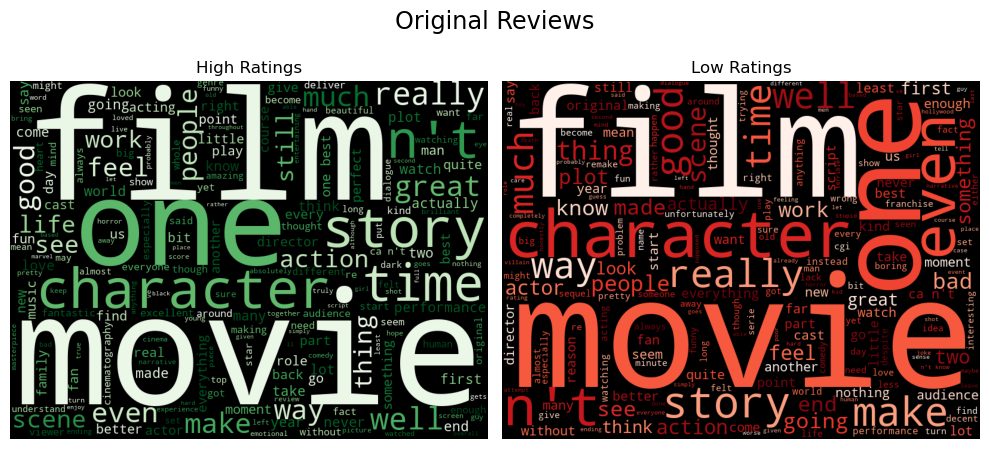

In [25]:
wordcloud_kws = dict(min_word_length=2,width=800, height=600, random_state=42)
high_cloud = WordCloud(**wordcloud_kws, colormap='Greens').generate(high_text_joined)
low_cloud = WordCloud(**wordcloud_kws, colormap='Reds').generate(low_text_joined)

fig = plot_wordclouds(high_cloud, low_cloud, title="Original Reviews")

In [26]:
all_high_lemmas = ' '.join(high['lemmas_joined'])
all_low_lemmas = ' '.join(low['lemmas_joined'])

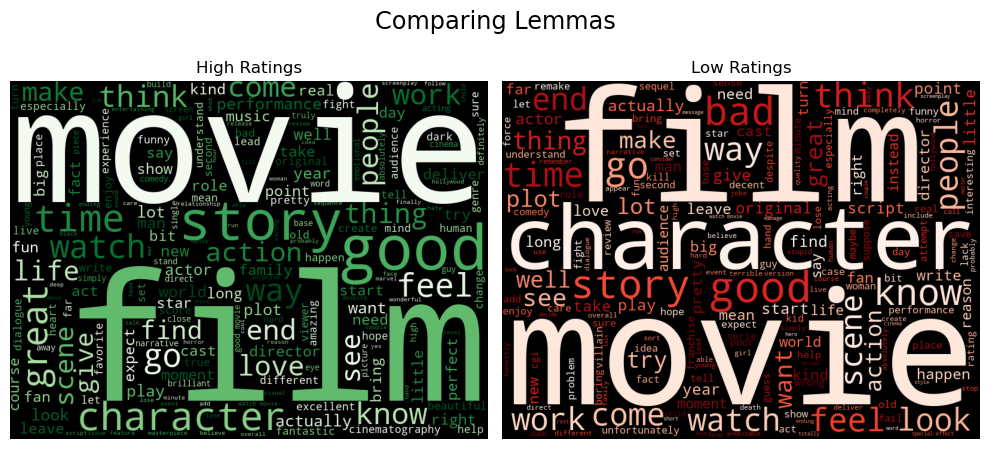

In [27]:
## Generate the WordCloud Images
# wordcloud_kws = dict(min_word_length=2,width=800, height=600, )
high_cloud = WordCloud(**wordcloud_kws, colormap='Greens').generate(all_high_lemmas)
low_cloud = WordCloud(**wordcloud_kws, colormap='Reds').generate(all_low_lemmas)

## Plot the Images
fig = plot_wordclouds(high_cloud, low_cloud, title='Comparing Lemmas')

In [28]:
# Add more custom stopwords for EDA
custom_stopwords = [*STOPWORDS,'movie','film','character','story','good']

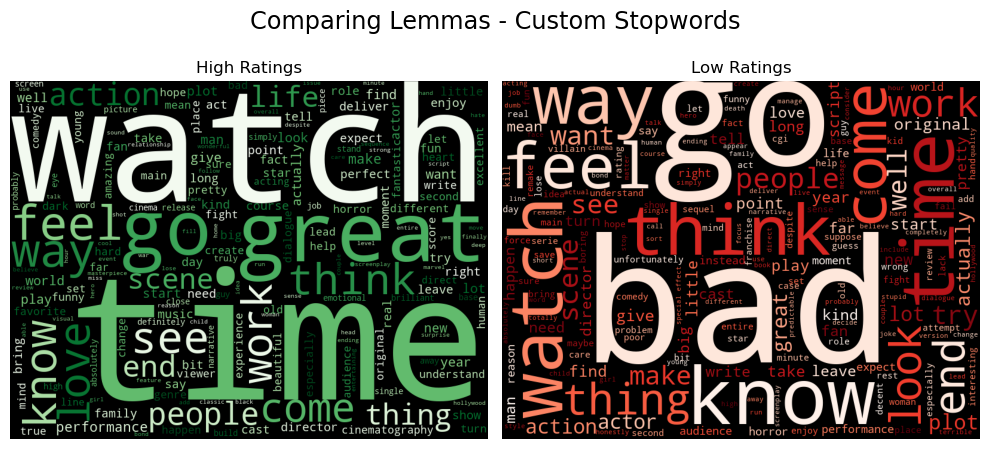

In [29]:
wordcloud_kws = dict(min_word_length=2,width=800, height=600, random_state=42,
                     stopwords=custom_stopwords)
high_cloud = WordCloud(**wordcloud_kws, colormap='Greens').generate(all_high_lemmas)
low_cloud = WordCloud(**wordcloud_kws, colormap='Reds').generate(all_low_lemmas)

# ## Plot the Images
fig =  plot_wordclouds(high_cloud,low_cloud, title="Comparing Lemmas - Custom Stopwords")

# Save figure
fig.savefig('Images/wordclouds-original-reviews-custom-stop.png', dpi=300,transparent=False, bbox_inches='tight')

In [30]:
## Create list of all tokens in all documents
high_tokens = high['clean_tokens'].explode().to_list()
low_tokens = low['clean_tokens'].explode().to_list()

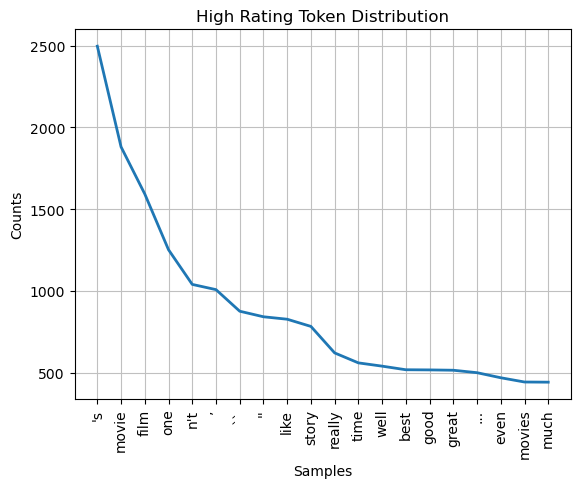

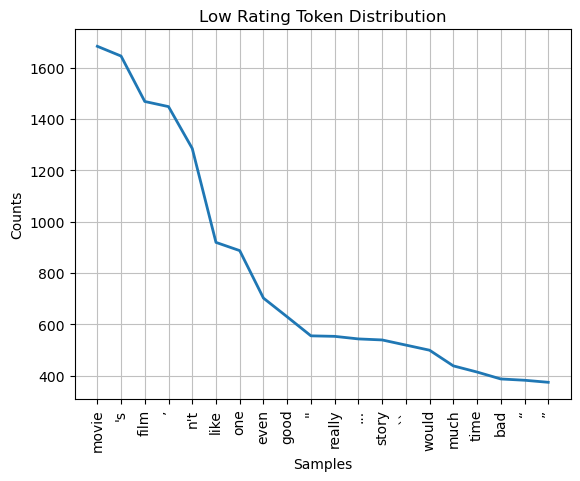

In [31]:
## Instantiate high frequency distribution
high_freq_dist = FreqDist(high_tokens)
low_freq_dist = FreqDist(low_tokens)

high_freq_dist.plot(20, title='High Rating Token Distribution')

low_freq_dist.plot(20, title='Low Rating Token Distribution');

In [32]:
high_lemmas = high['spacy_lemmas'].explode().to_list()
low_lemmas = low['spacy_lemmas'].explode().to_list()

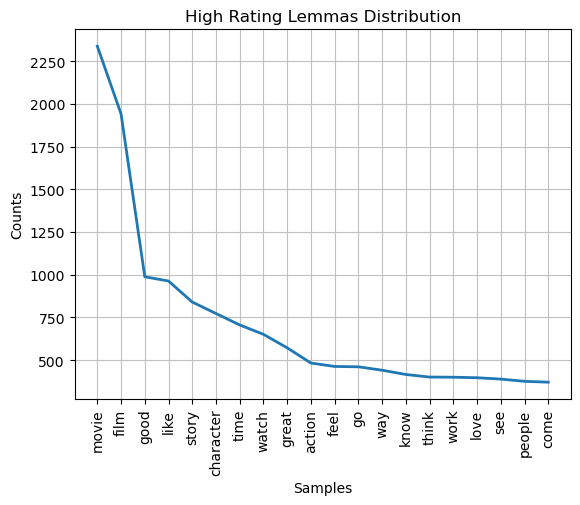

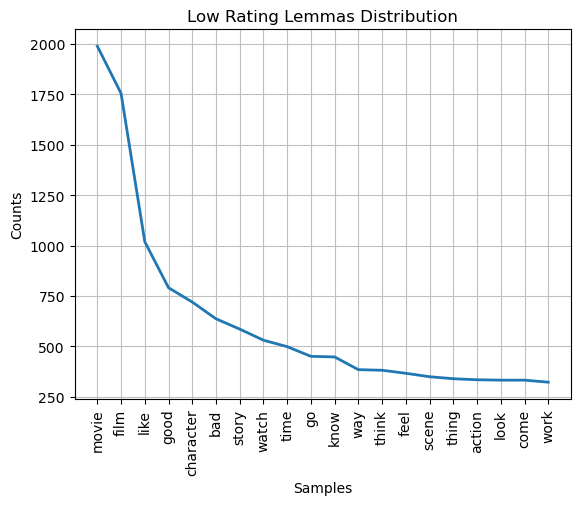

In [33]:
## Instantiate high frequency distribution
high_freq_dist = FreqDist(high_lemmas)
low_freq_dist = FreqDist(low_lemmas)

high_freq_dist.plot(20, title='High Rating Lemmas Distribution')

low_freq_dist.plot(20, title='Low Rating Lemmas Distribution');

In [34]:
## Create measure classes
measures = BigramAssocMeasures()

## Create collector classes
high_finder = BigramCollocationFinder.from_words(high_lemmas)
low_finder = BigramCollocationFinder.from_words(low_lemmas)

In [48]:
## Calculate high-rating ngram scores
high_ngram_scores = high_finder.score_ngrams(measures.raw_freq)
high_ngram_scores_df = pd.DataFrame(high_ngram_scores, columns=['high ngram', 'high score'])


## Calculate low-rating ngram scores
low_ngram_scores = low_finder.score_ngrams(measures.raw_freq)
low_ngram_scores_df = pd.DataFrame(low_ngram_scores, columns=['low ngram', 'low score'])

## Display the frequency scores
display(high_ngram_scores_df.head(10),low_ngram_scores_df.head(10))

,high ngram,high score
0,"(good, movie)",0.000812
1,"(feel, like)",0.000786
2,"(watch, movie)",0.000751
3,"(comic, book)",0.000577
4,"(good, film)",0.000568
5,"(action, movie)",0.000515
6,"(movie, like)",0.000507
7,"(like, movie)",0.000472
8,"(special, effect)",0.000463
9,"(main, character)",0.000446


,low ngram,low score
0,"(feel, like)",0.001224
1,"(look, like)",0.000885
2,"(special, effect)",0.000720
3,"(watch, movie)",0.000648
4,"(bad, movie)",0.000576
5,"(movie, like)",0.000535
6,"(good, movie)",0.000494
7,"(waste, time)",0.000453
8,"(bad, guy)",0.000432
9,"(like, movie)",0.000422


In [61]:
def plot_group_ngrams( low_ngram_scores, high_ngram_scores, 
                       plot_col_low="low score",top_n=20,
                      plot_col_high="high score",figsize=(12, 9),):
    # Get top n ngrams for both groups (set index for easier pandas plotting)
    top_n_ngrams_high = high_ngram_scores.set_index("high ngram").head(top_n)
    top_n_ngrams_low = low_ngram_scores.set_index("low ngram").head(top_n)

    ## Plot the ngram frequencies
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    #
    top_n_ngrams_high[plot_col_high].sort_values().plot(
        kind="barh", title="High-Rating Ngram Frequency", ax=axes[0], color="green"
    )

    top_n_ngrams_low[plot_col_low].sort_values().plot(
        kind="barh", title="Low-Rating Ngram Frequency", color="crimson", ax=axes[1]
    )
    for ax in axes:
        ax.spines["top"].set_visible(False)  # Remove the top spine
        ax.spines["right"].set_visible(False)  # Remove the right spine

    fig.tight_layout()
    return fig

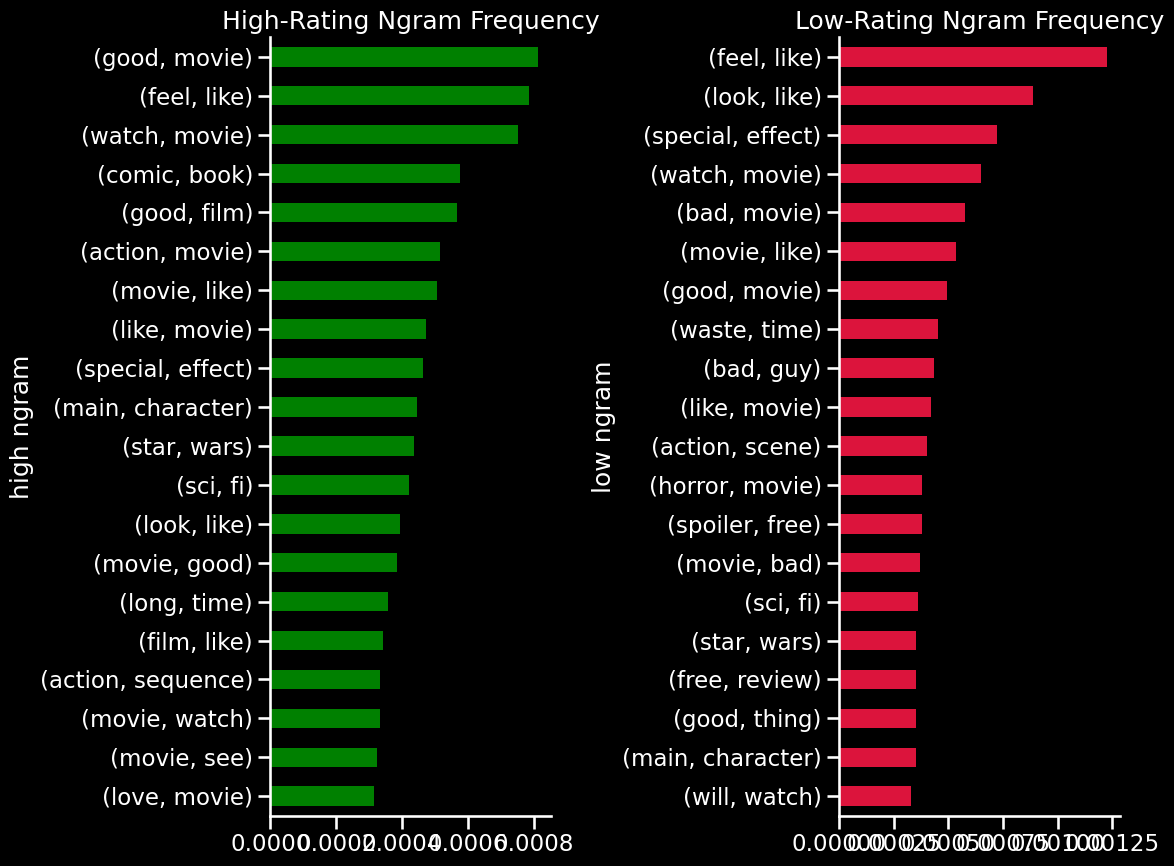

In [62]:
with plt.style.context(['dark_background',]):
    with sns.plotting_context("talk"):
        fig = plot_group_ngrams(low_ngram_scores_df, high_ngram_scores_df)

In [63]:
from nltk.collocations import TrigramAssocMeasures, TrigramCollocationFinder

## Create measure classes
measures = TrigramAssocMeasures()

## Create collector classes
high_finder = TrigramCollocationFinder.from_words(high_lemmas)
low_finder = TrigramCollocationFinder.from_words(low_lemmas)

In [64]:
## Calculate high-rating trigram scores
high_ngram_scores = high_finder.score_ngrams(measures.raw_freq)
# Save as a dataframe
high_ngram_scores_df = pd.DataFrame(high_ngram_scores, columns=['high ngram', 'high score'])



## Calculate low-rating ngram scores
low_ngram_scores = low_finder.score_ngrams(measures.raw_freq)
# Save as a dataframe
low_ngram_scores_df = pd.DataFrame(low_ngram_scores, columns=['low ngram', 'low score'])


## Display the frequency scores
display(high_ngram_scores_df.head(10),low_ngram_scores_df.head(10))

,high ngram,high score
0,"(spoiler, free, review)",0.000280
1,"(enjoy, read, spoiler)",0.000201
2,"(free, review, follow)",0.000201
3,"(read, spoiler, free)",0.000201
4,"(review, follow, blog)",0.000201
5,"(comic, book, movie)",0.000140
6,"(star, wars, movie)",0.000105
7,"(super, hero, movie)",0.000105
8,"(bong, joon, ho)",0.000087
9,"(world, war, z)",0.000087


,low ngram,low score
0,"(spoiler, free, review)",0.000350
1,"(will, watch, recommend)",0.000298
2,"(enjoy, read, spoiler)",0.000216
3,"(free, review, follow)",0.000216
4,"(read, spoiler, free)",0.000216
5,"(review, follow, blog)",0.000216
6,"(probably, will, watch)",0.000154
7,"(jake, watt, read)",0.000144
8,"(read, jake, article)",0.000144
9,"(watch, will, watch)",0.000144


In [65]:
def plot_group_ngrams( low_ngram_scores, high_ngram_scores, 
                       plot_col_low="low score",top_n=20,
                      plot_col_high="high score",figsize=(12, 8),):
    # Get top n ngrams for both groups (set index for easier pandas plotting)
    top_n_ngrams_high = high_ngram_scores.set_index("high ngram").head(top_n)
    top_n_ngrams_low = low_ngram_scores.set_index("low ngram").head(top_n)

    ## Plot the ngram frequencies
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    plt.xticks(rotation = 25)
    #
    top_n_ngrams_high[plot_col_high].sort_values().plot(
        kind="barh", title="High-Rating Trigram Frequency", ax=axes[0], color="green"
    )

    top_n_ngrams_low[plot_col_low].sort_values().plot(
        kind="barh", title="Low-Rating Trigram Frequency", color="crimson", ax=axes[1]
    )
    for ax in axes:
        ax.spines["top"].set_visible(False)  # Remove the top spine
        ax.spines["right"].set_visible(False)  # Remove the right spine

    fig.tight_layout()
    return fig

In [68]:
with plt.style.context(['dark_background',]):
    with sns.plotting_context("talk"):
        fig = plot_group_ngrams(low_trigram_scores_df, high_trigram_scores_df)

NameError: name 'low_trigram_scores_df' is not defined